### Living Arrangements Examples from CPS

September 1, 2020

Attempt at replication of [this](https://www.federalreserve.gov/econres/notes/feds-notes/an-early-evaluation-of-the-effects-of-the-pandemic-on-living-arrangements-and-household-formation-20200807.htm). Identifies several problems with bd CPS.

In [1]:
import pandas as pd
comp_data = pd.read_csv('fed_hh_example.csv')

import os
os.chdir('/home/brian/Documents/CPS/data/')

import re, struct
import numpy as np

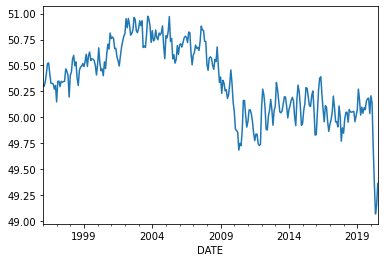

In [73]:
cols = ['QSTNUM', 'AGE', 'YEAR', 'MONTH', 'HHWGT', 'PWSSWGT']

df = pd.concat([pd.read_feather(f'clean/cps{year}.ft', columns=cols)
                  .query('AGE > 15') 
                for year in range(1996, 2021)])

headship_rate = (lambda grp: grp.groupby('QSTNUM').HHWGT.first().sum()
                 / grp.PWSSWGT.sum())
data = (df.groupby(['YEAR', 'MONTH']).apply(headship_rate)).reset_index()
data['DATE'] = pd.to_datetime(dict(year=data.YEAR, month=data.MONTH, day=1))
data = data.set_index('DATE').drop(['YEAR', 'MONTH'], axis=1) * 100
data.plot(legend=None);

<AxesSubplot:xlabel='DATE'>

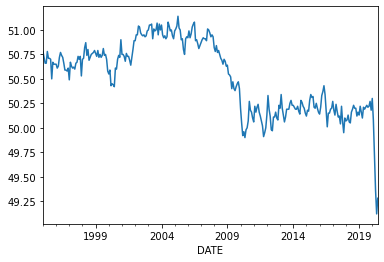

In [74]:
comp_data['DATE'] = pd.to_datetime(comp_data['date'])
comp_data.set_index('DATE')['headship'].plot()

In [75]:
comb = comp_data.set_index('DATE').join(data[0]).rename({'headship': 'Paciorek', 0: 'Dew'}, axis=1)

<AxesSubplot:xlabel='DATE'>

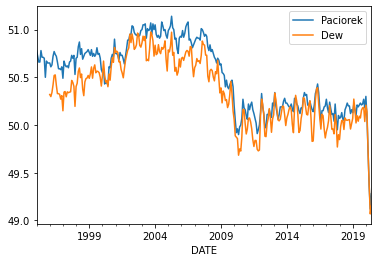

In [76]:
comb[['Paciorek', 'Dew']].plot()

<AxesSubplot:xlabel='DATE'>

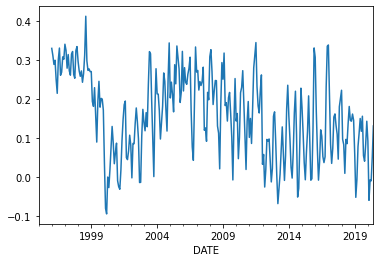

In [60]:
(comb['headship'] - comb[0]).plot()